In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Dense, Input, Concatenate, Reshape, Lambda
from keras.utils import plot_model
from scipy import stats as ss
from IPython.display import Image, display

Using TensorFlow backend.


In [2]:
def create_model(n_samples, out_dense_1, out_dense_2, kernel_size, n_kernels):    
    # Number of neurons for the dense layers.
    n_in_layer_1 = int(np.ceil((n_samples + kernel_size) / out_dense_2))
    
    # Shape of the output of the dense layers.
    out_dense_total = n_in_layer_1 * out_dense_2
    
    # Adjusts the kernel size to fit with the previously calculated parameters.
    kernel_size = out_dense_total - n_samples + 1

    print("out_dense_1:", out_dense_1, "\nout_dense_2:", out_dense_2, "\nn_in_layer_1:",
          n_in_layer_1, "\nout_dense_total:", out_dense_total, "\nkernel_size:", kernel_size,
          "\nn_kernels:", n_kernels)
    
    # Model input.
    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    # Create the first two (dense) layers.
    layer_1_a = []
    layer_2_a = []
    layer_1_b = []
    layer_2_b = []
    
    for i in range(n_in_layer_1):
        layer_1_a.append(Dense(out_dense_1, activation='relu', name='layer_1_a_{:02d}'.format(i))(model))
        layer_1_b.append(Dense(out_dense_1, activation='relu', name='layer_1_b_{:02d}'.format(i))(model))
        layer_2_a.append(Dense(out_dense_2, activation='relu', name='layer_2_a_{:02d}'.format(i))(layer_1_a[-1]))
        layer_2_b.append(Dense(out_dense_2, activation='relu', name='layer_2_b_{:02d}'.format(i))(layer_1_b[-1]))
    
    # Concatenate and reshape both sides.
    concat_a = Concatenate()(layer_2_a)
    print("Shape after concat_a:", concat_a.shape)
    
    reshape_a = Reshape(target_shape=(out_dense_total, 1, 1))(concat_a)
    print("Shape after reshape_a:", reshape_a.shape)
        
    concat_b = Concatenate()(layer_2_b)
    print("Shape after concat_b:", concat_b.shape)
    
    reshape_b = Reshape(target_shape=(out_dense_total, 1, 1))(concat_b)
    print("Shape after reshape_b:", reshape_b.shape)
    
    # Concatenate sides a and b.
    concat_both = Concatenate(-2)([reshape_a, reshape_b])
    print("Shape after concat_both:", concat_both.shape)
    
    # 2D Convolution and reshaping after concatenating
    conv = Conv2D(filters=n_kernels, kernel_size=(kernel_size, 2), strides=1)(concat_both)
    print("Shape after conv2d:", conv.shape)
    
    reshape_conv = Reshape(target_shape=(n_samples, n_kernels))(conv)
    print("Shape after reshape_conv:", reshape_conv.shape)
    
    avg = Lambda(lambda x: K.sum(x, axis=2), output_shape=lambda s: (s[0], s[1]))(reshape_conv)
    print("Shape after avg:", avg.shape)
    
    model = keras.Model(model, avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model

In [3]:
def gen_data(n_data, mu_range, sd_range, n_samples, x_range):

    # Generate spaces.
    mu, sd = np.meshgrid(np.linspace(mu_range[0], mu_range[1], n_data), np.linspace(sd_range[0], sd_range[1], n_data))
    mu, sd = mu.ravel(), sd.ravel()
    x = np.linspace(x_range[0], x_range[1], n_samples)

    # Sample from standard normal distribution.
    x_sampled = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])

    # Transform mu to match input format.
    params = np.array((mu, sd)).T
    
    return params, x_sampled

In [4]:
# Parameters to set.
N_DATA = 500  # Number of parameter samples
N_SAMPLES = 100  # Number of data samples

# Parameter-specific settings.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

out_dense_1: 10 
out_dense_2: 40 
n_in_layer_1: 4 
out_dense_total: 160 
kernel_size: 61 
n_kernels: 50
Shape after input: (?, 2)
Instructions for updating:
Colocations handled automatically by placer.
Shape after concat_a: (?, 160)
Shape after reshape_a: (?, 160, 1, 1)
Shape after concat_b: (?, 160)
Shape after reshape_b: (?, 160, 1, 1)
Shape after concat_both: (?, 160, 2, 1)
Shape after conv2d: (?, 100, 1, 50)
Shape after reshape_conv: (?, 100, 50)
Shape after avg: (?, 100)


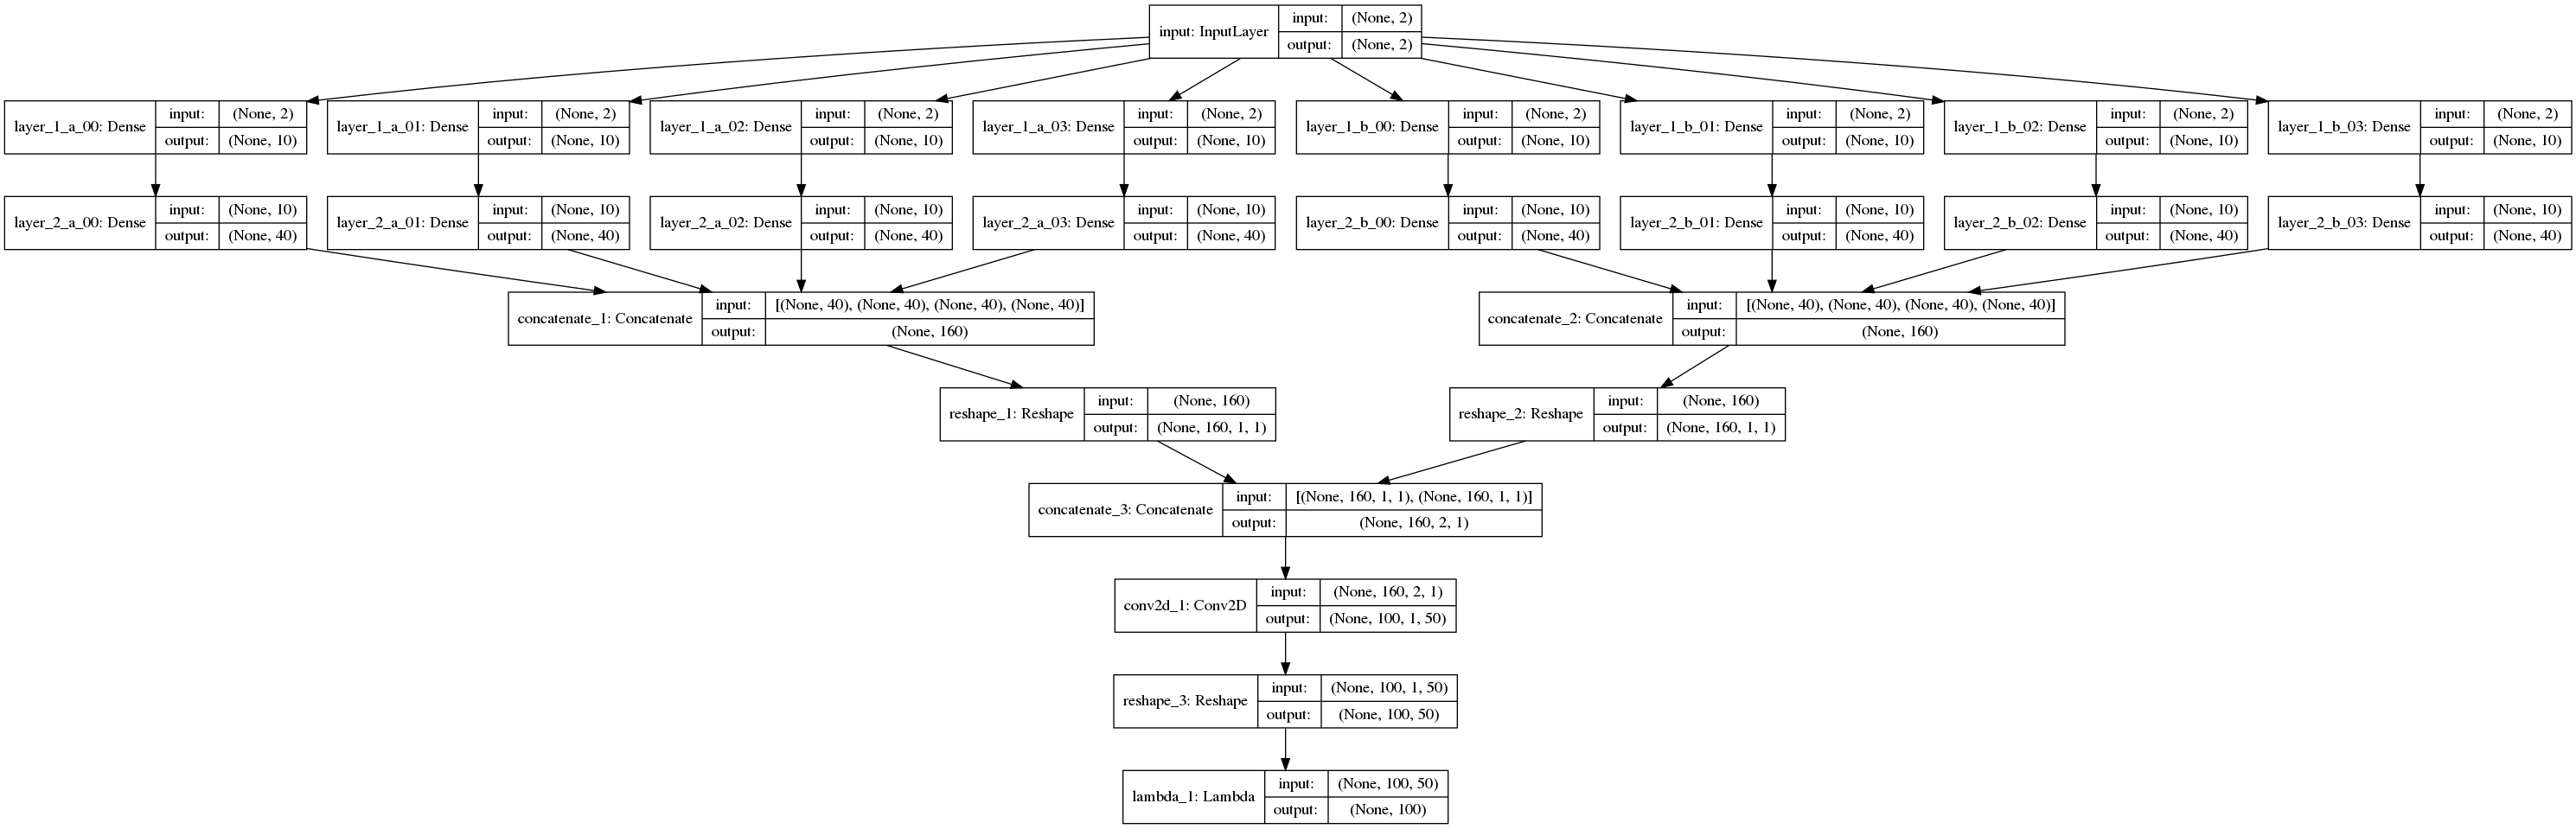

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
250000/250000 [==============================] - 19s 77us/step - loss: 17.1508
Epoch 2/5
250000/250000 [==============================] - 19s 78us/step - loss: 0.1358
Epoch 3/5
250000/250000 [==============================] - 19s 75us/step - loss: 0.0965
Epoch 4/5
250000/250000 [==============================] - 19s 76us/step - loss: 0.0829
Epoch 5/5
250000/250000 [==============================] - 19s 77us/step - loss: 0.0702


In [5]:
params, x_sampled = gen_data(N_DATA, [MIN_MU, MAX_MU], [MIN_SD, MAX_SD], N_SAMPLES, [MIN_X, MAX_X])
model = create_model(N_SAMPLES, 10, 40, 40, 50)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(params, x_sampled, shuffle=True, batch_size=32, epochs=5)

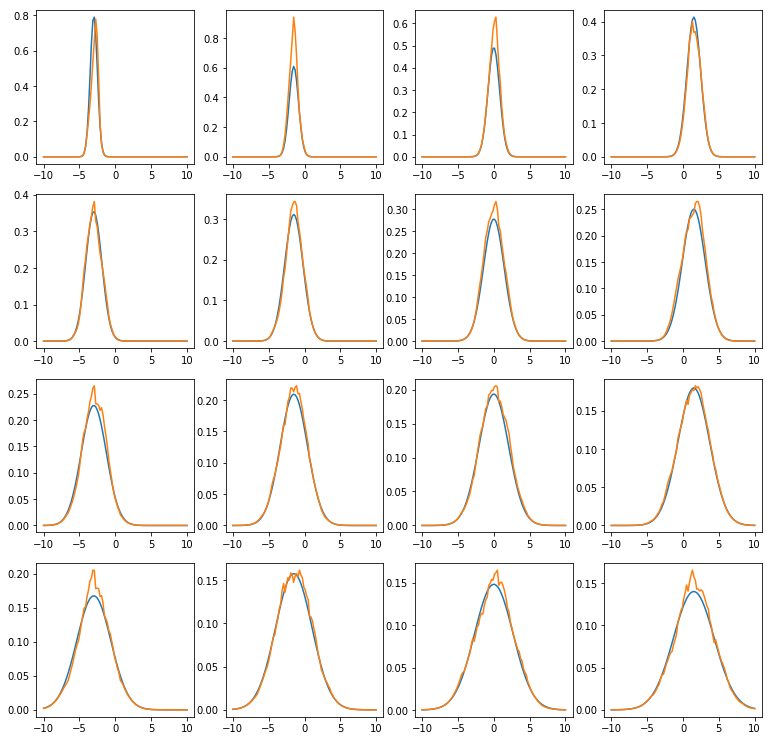

In [6]:
predictions = model.predict(params)

plt.figure(figsize=(13, 13))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.linspace(-10, 10, N_SAMPLES), np.exp(x_sampled[ix, :]))
    plt.plot(np.linspace(-10, 10, N_SAMPLES), np.exp(predictions[ix, :]))